In [1]:
from utils import create_grover_circuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit_aer.noise import amplitude_damping_error, phase_damping_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def modelo_de_ruido(gate_error=0.001, measurement_error=0.01):
    """
    ruido uniforme
    
    Args:
        gate_error: probabilidad de error
        measurement_error: probabildad para medidas
    
    Returns:
        NoiseModel
    """
    noise_model = NoiseModel()
    
    # 1qubit (H, X, etc.)
    error_1q = depolarizing_error(gate_error, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
    
    # 2qb (CX, CCX)
    error_2q = depolarizing_error(gate_error * 10, 2)  # empeora en 10x 
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    # para A de Grover
    error_mcx = depolarizing_error(gate_error * 20, 3)  # mas pior
    noise_model.add_all_qubit_quantum_error(error_mcx, ['mcx'])
    
    # Measurement errors
    error_meas = [[1 - measurement_error, measurement_error],
        [measurement_error, 1 - measurement_error]]
    noise_model.add_all_qubit_readout_error(error_meas)
    
    return noise_model

In [2]:
# --- Parámetros para la Experimentación ---
qubit_range = [4, 6, 8, 12]  
error_range = np.logspace(-4, -2, 5)
shots = 2048
results_data = []


--- Probando con 4 qubits (clave: 0101) ---
  Corriendo con error de compuerta: 0.0001
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0003
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0010
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0032
Número de qubits: 4, Iteraciones de Grover: 3
  Corriendo con error de compuerta: 0.0100
Número de qubits: 4, Iteraciones de Grover: 3

--- Probando con 6 qubits (clave: 011010) ---
  Corriendo con error de compuerta: 0.0001
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0003
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0010
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0032
Número de qubits: 6, Iteraciones de Grover: 6
  Corriendo con error de compuerta: 0.0100
Número de qubits: 6, Iteraciones de Grover: 6

--- Probando con 

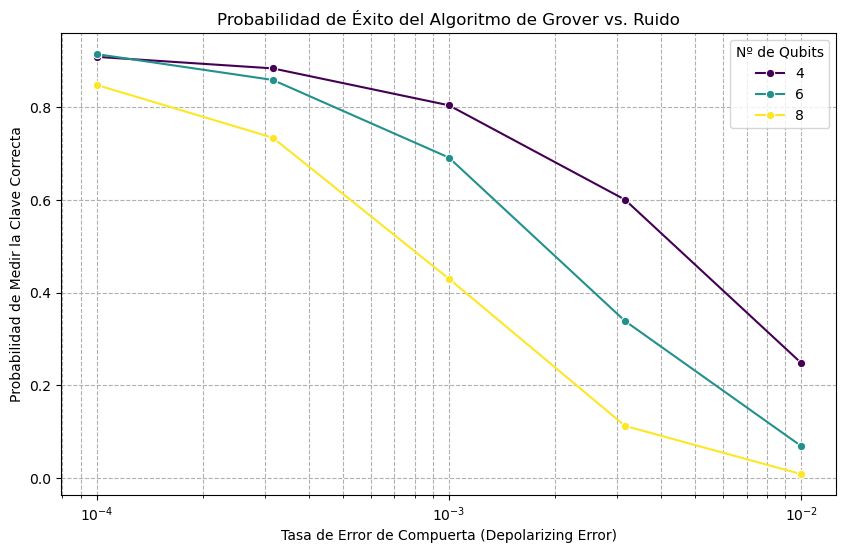

In [3]:
# --- Bucle de Simulación ---
for n_qubits in qubit_range:
    # Generar una clave secreta aleatoria para este tamaño
    secret_key = ''.join(np.random.choice(['0', '1'], size=n_qubits))
    print(f"\n--- Probando con {n_qubits} qubits (clave: {secret_key}) ---")
    
    for gate_error in error_range:
        print(f"  Corriendo con error de compuerta: {gate_error:.4f}")
        
        # 1. Crear el modelo de ruido
        noise_environment = modelo_de_ruido(gate_error=gate_error)
        backend = AerSimulator(noise_model=noise_environment)
        
        # 2. Crear y transpilar el circuito de Grover
        grover_circuit = create_grover_circuit(n_qubits, secret_key)
        transpiled_circuit = transpile(grover_circuit, backend)
        
        # 3. Ejecutar la simulación
        job = backend.run(transpiled_circuit, shots=shots)
        results = job.result()
        counts = results.get_counts(transpiled_circuit)
        
        # 4. Calcular y almacenar la probabilidad de éxito
        success_prob = counts.get(secret_key, 0) / shots
        results_data.append({
            'n_qubits': n_qubits,
            'gate_error': gate_error,
            'success_prob': success_prob
        })

# --- Análisis y Visualización de Resultados ---
df = pd.DataFrame(results_data)
print("\n--- Resultados del Experimento ---")
print(df)

# Crear la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='gate_error', y='success_prob', hue='n_qubits', marker='o', palette='viridis')

plt.xscale('log')
plt.title('Probabilidad de Éxito del Algoritmo de Grover vs. Ruido')
plt.xlabel('Tasa de Error de Compuerta (Depolarizing Error)')
plt.ylabel('Probabilidad de Medir la Clave Correcta')
plt.grid(True, which="both", ls="--")
plt.legend(title='Nº de Qubits')
plt.show()